Excitatory point processes describe random event sequences in which new arrivals increase rates of future occurrence. The excitation framework has significant applications to fields that feature elements of temporal clustering across different dimensions; examples include modeling of earthquake aftershocks, crime rates, and financial contagion.

The multivariate Hawkes Process put forward in Hawkes (1971) is a popular model for excitatory point processes. Its conditional intensity function (CIF) leverages a Poissonian background process to generate immigrant events with independent arrival times; immigrants then excite arrivals of offspring events, which themselves generate more offspring.

Alternatively, the generating process can be reframed as a mixture of independent Poisson processes, namely the immigrant-generating background rate and past arrivals’ time-decaying excitatory influence. The Hawkes process therefore lends itself to a branching structure, whereby each arrival is spawned by a single generating process in the Poissonian mixture.

This package provides easy and fast simulation and parameter estimation for multivariate Hawkes processes with exponential memory kernels. Both stationary and time-varying background rates are considered.

In [32]:
#!python setup.py build_ext --inplace <- to convert cython file to c

In [31]:
from hawkes_estimator import *
from numpy.random import uniform
from numpy import fill_diagonal,sqrt,ndarray
import matplotlib.pyplot as plt

# Multivariate Hawkes Process

### Generate Example Hawkes Parameters

In [2]:
DIMS = 4 # num dimensions
BACKGROUND_RATE_BOUNDS = [0.4,0.6] # mu bounds
SELF_EXCITATION_RATE_BOUNDS = [0.3,0.4] # alpha matrix diagonal bounds
MUTUAL_EXCITATION_RATE_BOUNDS = [0.05,0.1] # alpha matrix non-diagonal bounds
DECAY_BOUNDS = [0.5,0.6] # beta bounds

In [3]:
# generate random parameters given above bounds
def generate_params(U,mu_bnd,alpha_diag_bnd,alpha_nondiag_bnd,beta_bnd):
    mu = uniform(mu_bnd[0],mu_bnd[1],U)
    alpha = uniform(alpha_nondiag_bnd[0],alpha_nondiag_bnd[1],(U,U))
    fill_diagonal(alpha,uniform(alpha_diag_bnd[0],alpha_diag_bnd[1],U))
    beta = uniform(beta_bnd[0],beta_bnd[1])
    return mu,alpha,beta

In [4]:
mu,alpha,beta = generate_params(DIMS,BACKGROUND_RATE_BOUNDS,SELF_EXCITATION_RATE_BOUNDS,MUTUAL_EXCITATION_RATE_BOUNDS,DECAY_BOUNDS)

### Simulate Hawkes Process

In [5]:
hwk = HawkesEM()

In [6]:
hwk.simulate_data(params=(mu,alpha,beta),N=100000)
# hwk.load_data(t,u) <- if importing data from elsewhere

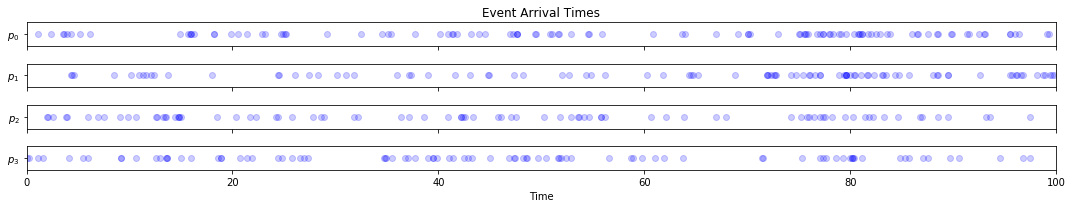

In [7]:
hwk.plot_events(horizon=100)

### Estimate Hawkes Parameters (Known Decay)

In [8]:
mu_hat,alpha_hat = hwk.fit(beta,eps=0.001,inc=20,verbose=True)

Preparation ->   0.03s ----------------
Epoch    20 ->   0.09s ----------------
Epoch    40 ->   0.15s - diff: 1.32e+01
Epoch    60 ->   0.22s - diff: 2.62e+00
Epoch    80 ->   0.30s - diff: 7.65e-01
Epoch   100 ->   0.37s - diff: 2.48e-01
Epoch   120 ->   0.43s - diff: 8.67e-02
Epoch   140 ->   0.50s - diff: 3.22e-02
Epoch   160 ->   0.56s - diff: 1.26e-02
Epoch   180 ->   0.63s - diff: 5.16e-03
Epoch   200 ->   0.70s - diff: 2.18e-03
Epoch   220 ->   0.77s - diff: 9.35e-04


In [9]:
def RMSE(pred,actual):
    return sqrt(((pred-actual)**2).mean())

In [10]:
mu_RMSE = RMSE(mu,mu_hat)
alpha_RMSE = RMSE(alpha,alpha_hat)

In [11]:
print("Background Rates RMSE = {}".format(round(mu_RMSE,2)))
print("Excitation Rates RMSE = {}".format(round(alpha_RMSE,2)))

Background Rates RMSE = 0.02
Excitation Rates RMSE = 0.01


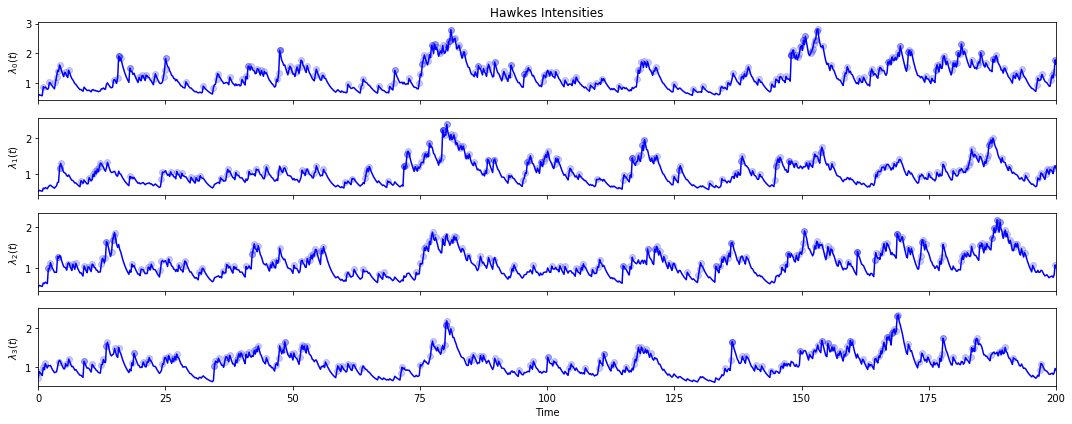

In [12]:
params = mu_hat,alpha_hat,beta
hwk.plot_intensities(params,horizon=200)

### Estimate Hawkes Parameters (Unknown Decay)

In [13]:
mu_hat,alpha_hat,beta_hat = hwk.fit(eps=0.001,inc=20,verbose=True)

beta =  0.0000 ->   0.00s - loglike: -1.000000e+06
beta =  1.0000 ->   0.74s - loglike: -8.675142e+04
beta =  2.0000 ->   1.31s - loglike: -8.737694e+04
beta =  1.5000 ->   1.89s - loglike: -8.708359e+04
beta =  0.7500 ->   2.78s - loglike: -8.660967e+04
beta =  0.5000 ->   3.72s - loglike: -8.658201e+04
beta =  0.2500 ->   4.88s - loglike: -8.698338e+04
beta =  0.3750 ->   5.91s - loglike: -8.668811e+04
beta =  0.5625 ->   6.67s - loglike: -8.656820e+04
beta =  0.6250 ->   7.41s - loglike: -8.657107e+04
beta =  0.5312 ->   8.31s - loglike: -8.657266e+04
beta =  0.5781 ->   9.11s - loglike: -8.656756e+04
beta =  0.5938 ->   9.87s - loglike: -8.656787e+04
beta =  0.5859 ->  10.66s - loglike: -8.656761e+04
beta =  0.5742 ->  12.26s - loglike: -8.656763e+04
beta =  0.5801 ->  13.10s - loglike: -8.656755e+04
beta =  0.5811 ->  13.85s - loglike: -8.656755e+04
beta =  0.5821 ->  14.75s - loglike: -8.656755e+04


In [14]:
mu_RMSE = RMSE(mu,mu_hat)
alpha_RMSE = RMSE(alpha,alpha_hat)
beta_RMSE = RMSE(beta,beta_hat)

In [15]:
print("Background Rates RMSE = {}".format(round(mu_RMSE,2)))
print("Excitation Rates RMSE = {}".format(round(alpha_RMSE,2)))
print("Decay Rate RMSE = {}".format(round(alpha_RMSE,2)))

Background Rates RMSE = 0.02
Excitation Rates RMSE = 0.01
Decay Rate RMSE = 0.01


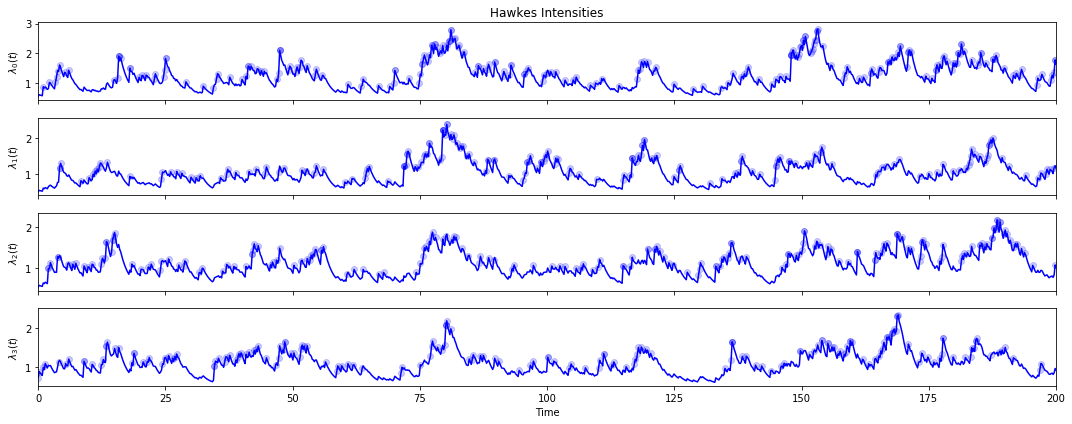

In [16]:
params = mu_hat,alpha_hat,beta_hat
hwk.plot_intensities(params,horizon=200)

# Multivariate Hakwes Process with Time-Varying Background Rate

### Generate Example Time-Varying Hawkes Parameters

In [17]:
# using mu, alpha, beta from above example**
# example time-varying background rate function
freqs = np.array([100,200])/(2*np.pi)
amp = np.array([0.3,0.3])
offset = 100
def f(x):
    def fi(x):
        return np.sum(amp*np.cos((x-offset)/freqs)) + np.sum(amp)
    if type(x) != ndarray:
        return fi(x)
    else:
        return np.array([fi(xi) for xi in x])

In [18]:
# background rate average and maximum
x = np.arange(0,1000,0.1)
favg = np.mean(f(x))
fmax = np.max(f(x))*1.1
bkgd_params = (f,fmax,favg)

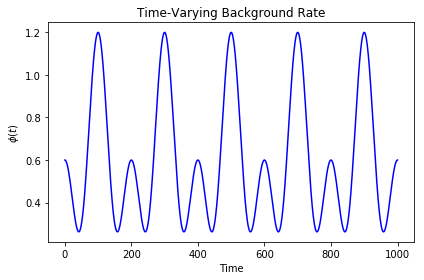

In [19]:
# plot time-varying background rate
fig,ax = plt.subplots()
ax.plot(x, f(x), color='blue')
ax.set_title('Time-Varying Background Rate')
ax.set_xlabel('Time')
ax.set_ylabel('$\phi(t)$')
fig.tight_layout()

### Simulate Hawkes Process

In [20]:
hwk = TimeVarHawkesEM()

In [21]:
hwk.simulate_data(params=(mu,alpha,beta,bkgd_params),N=100000)
# hwk.load_data(t,u,bkgd) <- if importing data from elsewhere

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:13<00:00, 7329.11it/s]


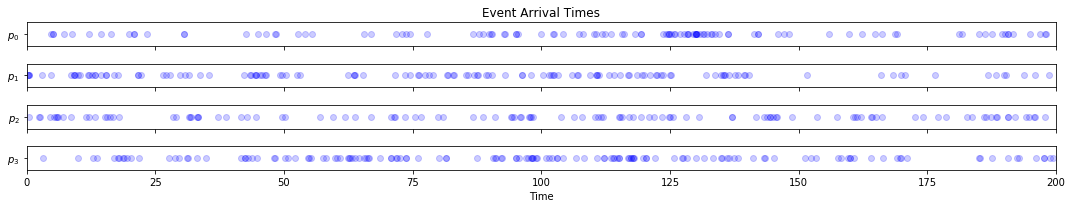

In [22]:
hwk.plot_events(horizon=200)

### Estimate Hawkes Parameters (Known Decay)

In [23]:
mu_hat,alpha_hat = hwk.fit(beta,eps=0.001,inc=20,verbose=True)

Preparation ->   0.03s ----------------
Epoch    20 ->   0.11s ----------------
Epoch    40 ->   0.18s - diff: 2.06e+01
Epoch    60 ->   0.26s - diff: 2.52e+00
Epoch    80 ->   0.32s - diff: 3.53e-01
Epoch   100 ->   0.39s - diff: 6.18e-02
Epoch   120 ->   0.47s - diff: 1.26e-02
Epoch   140 ->   0.54s - diff: 2.83e-03
Epoch   160 ->   0.61s - diff: 6.64e-04


In [24]:
mu_RMSE = RMSE(mu,mu_hat)
alpha_RMSE = RMSE(alpha,alpha_hat)

In [25]:
print("Background Rates RMSE = {}".format(round(mu_RMSE,2)))
print("Excitation Rates RMSE = {}".format(round(alpha_RMSE,2)))

Background Rates RMSE = 0.02
Excitation Rates RMSE = 0.01


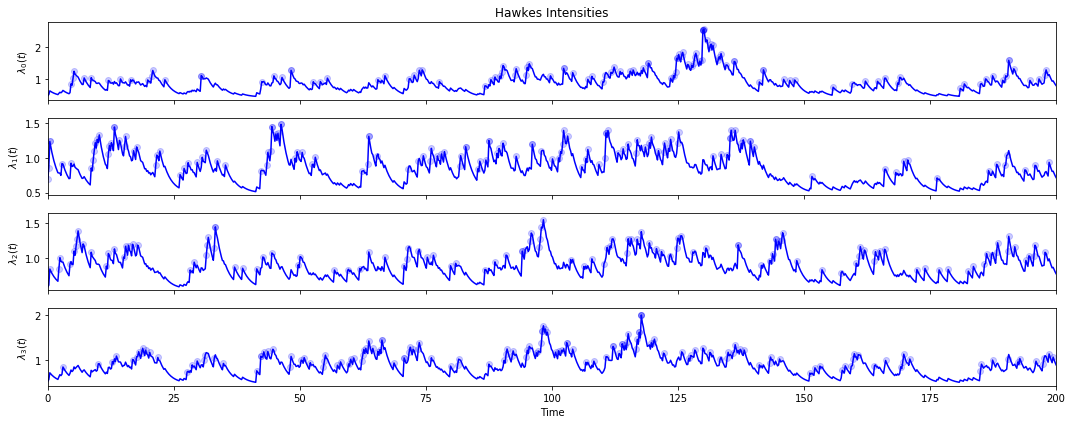

In [26]:
params = mu_hat,alpha_hat,beta
hwk.plot_intensities(params,horizon=200)

### Estimate Hawkes Parameters (Unknown Decay)

In [27]:
mu_hat,alpha_hat,beta_hat = hwk.fit(eps=0.001,inc=20,verbose=True)

beta =  0.0000 ->   0.00s - loglike: -1.000000e+06
beta =  1.0000 ->   0.53s - loglike: -1.259137e+05
beta =  2.0000 ->   0.99s - loglike: -1.269758e+05
beta =  1.5000 ->   1.46s - loglike: -1.264791e+05
beta =  0.7500 ->   2.00s - loglike: -1.256706e+05
beta =  0.5000 ->   2.61s - loglike: -1.256194e+05
beta =  0.2500 ->   3.76s - loglike: -1.263425e+05
beta =  0.3750 ->   4.43s - loglike: -1.258020e+05
beta =  0.5625 ->   5.09s - loglike: -1.255970e+05
beta =  0.6250 ->   5.91s - loglike: -1.256030e+05
beta =  0.5938 ->   6.52s - loglike: -1.255970e+05
beta =  0.5469 ->   7.06s - loglike: -1.255995e+05
beta =  0.5703 ->   7.66s - loglike: -1.255963e+05
beta =  0.5781 ->   8.26s - loglike: -1.255962e+05
beta =  0.5859 ->   8.86s - loglike: -1.255964e+05
beta =  0.5820 ->   9.45s - loglike: -1.255962e+05
beta =  0.5762 ->   9.99s - loglike: -1.255962e+05
beta =  0.5791 ->  10.59s - loglike: -1.255962e+05


In [28]:
mu_RMSE = RMSE(mu,mu_hat)
alpha_RMSE = RMSE(alpha,alpha_hat)
beta_RMSE = RMSE(beta,beta_hat)

In [29]:
print("Background Rates RMSE = {}".format(round(mu_RMSE,2)))
print("Excitation Rates RMSE = {}".format(round(alpha_RMSE,2)))
print("Decay Rate RMSE = {}".format(round(alpha_RMSE,2)))

Background Rates RMSE = 0.02
Excitation Rates RMSE = 0.01
Decay Rate RMSE = 0.01


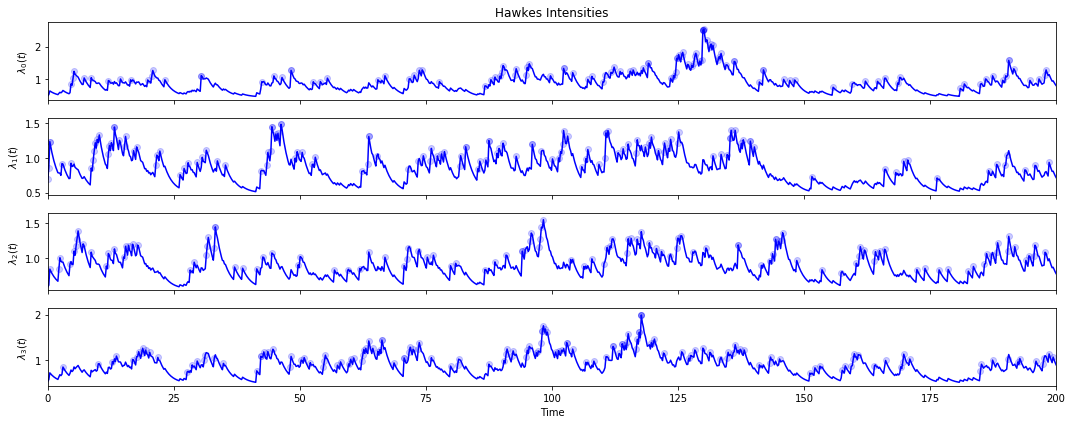

In [30]:
params = mu_hat,alpha_hat,beta_hat
hwk.plot_intensities(params,horizon=200)